In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from __future__ import division
import os, scipy.io
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import rawpy
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import image

In [3]:
def lrelu(x):
    return tf.maximum(x * 0.2, x)

def upsample_and_concat(x1, x2, output_channels, in_channels):
    pool_size = 2
    deconv_filter = tf.Variable(tf.truncated_normal([pool_size, pool_size, output_channels, in_channels], stddev=0.02))
    deconv = tf.nn.conv2d_transpose(x1, deconv_filter, tf.shape(x2), strides=[1, pool_size, pool_size, 1])

    deconv_output = tf.concat([deconv, x2], 3)
    deconv_output.set_shape([None, None, None, output_channels * 2])

    return deconv_output

def network(input):
    conv1 = slim.conv2d(input, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_1')
    conv1 = slim.conv2d(conv1, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_2')
    pool1 = slim.max_pool2d(conv1, [2, 2], padding='SAME')

    conv2 = slim.conv2d(pool1, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_1')
    conv2 = slim.conv2d(conv2, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_2')
    pool2 = slim.max_pool2d(conv2, [2, 2], padding='SAME')

    conv3 = slim.conv2d(pool2, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_1')
    conv3 = slim.conv2d(conv3, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_2')
    pool3 = slim.max_pool2d(conv3, [2, 2], padding='SAME')

    conv4 = slim.conv2d(pool3, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_1')
    conv4 = slim.conv2d(conv4, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_2')
    pool4 = slim.max_pool2d(conv4, [2, 2], padding='SAME')

    conv5 = slim.conv2d(pool4, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_1')
    conv5 = slim.conv2d(conv5, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_2')

    up6 = upsample_and_concat(conv5, conv4, 256, 512)
    conv6 = slim.conv2d(up6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_1')
    conv6 = slim.conv2d(conv6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_2')

    up7 = upsample_and_concat(conv6, conv3, 128, 256)
    conv7 = slim.conv2d(up7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_1')
    conv7 = slim.conv2d(conv7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_2')

    up8 = upsample_and_concat(conv7, conv2, 64, 128)
    conv8 = slim.conv2d(up8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_1')
    conv8 = slim.conv2d(conv8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_2')

    up9 = upsample_and_concat(conv8, conv1, 32, 64)
    conv9 = slim.conv2d(up9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_1')
    conv9 = slim.conv2d(conv9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_2')

    conv10 = slim.conv2d(conv9, 12, [1, 1], rate=1, activation_fn=None, scope='g_conv10')
    out = tf.depth_to_space(conv10, 2)
    return out

def pack_raw(raw,black_level=512,white_level=16383):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - black_level, 0) / (white_level - black_level)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out

In [4]:
checkpoint_dir = './checkpoint/Sony/'

In [5]:
sess = tf.Session()
in_image = tf.placeholder(tf.float32, [None, None, None, 4])
gt_image = tf.placeholder(tf.float32, [None, None, None, 3])
out_image = network(in_image)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded ' + ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)

loaded ./checkpoint/Sony/model.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/Sony/model.ckpt


In [6]:
ratio = 1

In [7]:
raw = rawpy.imread('../train.ARW')
input_full = np.expand_dims(pack_raw(raw), axis=0) * ratio
input_full = np.minimum(input_full, 1.0)

In [8]:
im = raw.postprocess(use_camera_wb=True, half_size=True, no_auto_bright=True, output_bps=16)
scale_full = np.expand_dims(np.float32(im / 65535.0), axis=0)

In [9]:
H, W = input_full.shape[1:3]
HP, WP = H//512, W//512
HH, WW = HP*512, WP*512

In [10]:
center_full = input_full[:,(H-HH)//2:(H-HH)//2+HH,(W-WW)//2:(W-WW)//2+WW,:]

In [11]:
output_full = np.zeros((center_full.shape[1]*2,center_full.shape[2]*2,3))
for hp in range(HP):
    for wp in range(WP):
        patch = center_full[:,512*hp:512*(hp+1),512*wp:512*(wp+1),:]

        output = sess.run(out_image, feed_dict={in_image: patch})
        output = np.minimum(np.maximum(output, 0), 1)
        
        output_full[1024*hp:1024*(hp+1),1024*wp:1024*(wp+1),:] = output

In [12]:
output = cv2.resize(output_full,(output_full.shape[1]//2,output_full.shape[0]//2))

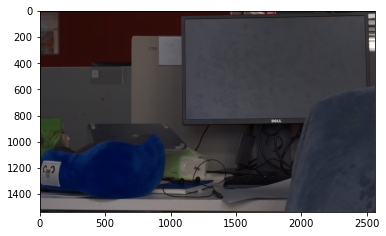

In [13]:
plt.imshow(output)

In [70]:
image.imsave('out.png',np.clip(output[:,:,:] * 255, 0, 255).astype(np.uint8))